## Set working directory

In [ ]:
import os
os.chdir('/home/mhoerold/entrack')

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import nibabel as nib
import copy

from src.baum_vagan.vagan.model_wrapper import VAGanWrapper
from src.baum_vagan.utils import ncc
from src.data.streaming.vagan_streaming import MRIImagePair, AgeFixedDeltaStream
from src.baum_vagan.utils import map_image_to_intensity_range

## Load model for evaluation

In [ ]:
smt_label = "dummy_fixed_delta_model"
config_path = os.path.join("data", smt_label, "config.yaml")
model_dir = os.path.join("data", smt_label, "logdir")
with open(config_path, 'r') as f:
    model_config = yaml.load(f)
wrapper = VAGanWrapper(**model_config)
wrapper.vagan.load_weights(model_dir)
vagan = wrapper.vagan

In [ ]:
## Some streamers
train_stream = lambda bs: wrapper.data.trainAD.next_batch(bs)[0]
validation_stream = lambda bs: wrapper.data.validationAD.next_batch(bs)[0]
test_stream = lambda bs: wrapper.data.testAD.next_batch(bs)[0]

n_train_samples = wrapper.data.n_train_samples
n_val_samples = wrapper.data.n_val_samples
n_test_samples = wrapper.data.n_test_samples

# Input wrapper
input_wrapper = wrapper.config.input_wrapper
gt_channel = 1

In [ ]:
def extract_x_t0_x_t1_delta_x_t0(batch):
    x_t0 = batch[:, :, :, :, 0:1]
    delta_x_t0 = batch[:, :, :, :, 1:2]
    x_t1 = x_t0 + delta_x_t0
    return x_t0, x_t1, delta_x_t0

## Compute scores (e.g. NCC)

In [ ]:
streamers = [
    {
        "streamer": test_stream,
        "name": "test",
        "n_samples": n_test_samples
    },
    {
        "streamer": validation_stream,
        "name": "validation",
        "n_samples": n_val_samples
    },
    {
        "streamer": train_stream,
        "name": "train",
        "n_samples": n_train_samples
    }
]

for s in streamers:
    stream = s["streamer"]
    name = s["name"]
    n_samples = s ["n_samples"]
    print("Evaluating {}".format(name))
    scores = []
    for _ in range(n_samples):
        inp = stream(1)
        diff_map = vagan.predict_mask(inp)
        # wrapped = input_wrapper(inp)
        gt = inp[:, :, :, :, gt_channel:gt_channel + 1]
        sc = ncc(diff_map, gt)
        scores.append(sc)
        
    print("NCC: mean {}, std {}, median {}"
          .format(np.mean(scores), np.std(scores), np.median(scores)))

## Analyze slices of generated difference map

In [ ]:
def difference_map_comparison(diff_map_1, diff_map_2):
    nrows = 1
    ncols = 3
    
    plt.figure(figsize=(20, 10))
    # Difference
    plt.subplot(nrows, ncols, 1)
    im = diff_map_2 - diff_map_1
    plt.imshow(im, cmap='bwr')
    plt.title("map2 - map1")
    plt.axis('off')
    
    # Absolute difference
    plt.subplot(nrows, ncols, 2)
    im = np.abs(diff_map_1 - diff_map_2)
    plt.imshow(im, cmap='gray')
    plt.title("Absolute difference")
    plt.axis('off')
    
    # Element-wise product
    plt.subplot(nrows, ncols, 3)
    im = diff_map_1 * diff_map_2
    plt.imshow(im, cmap='bwr', vmin=-1, vmax=1)
    ncc_sc = round(ncc(diff_map_1, diff_map_2)[0], 4)
    plt.title("Element-wise product, ncc={}".format(str(ncc_sc)))
    plt.axis('off')
    
def plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, axis, slice_idx, im_pair):
    x_t1_gen = x_t0 + delta_gen
    
    t0 = round(im_pair.age1, 2)
    t1 = round(im_pair.age2, 2)
    
    x_t0 = np.squeeze(np.take(x_t0, slice_idx, axis=axis))
    x_t1 = np.squeeze(np.take(x_t1, slice_idx, axis=axis))
    delta_x_t0 = np.squeeze(np.take(delta_x_t0, slice_idx, axis=axis))
    delta_gen = np.squeeze(np.take(delta_gen, slice_idx, axis=axis))
    x_t1_gen = np.squeeze(np.take(x_t1_gen, slice_idx, axis=axis))
    
    figsize = (20, 20)
    fs = 20
    fig = plt.figure(figsize=figsize, edgecolor='black', linewidth=0.1)
    plt.subplots_adjust(hspace=0.2, bottom=0.1)
    
    ax1 = fig.add_subplot(231)
    ax1.set_title("x_t0 {}".format(str(t0)), size=fs)
    ax1.imshow(x_t0, cmap='gray')
    
    ax2 = fig.add_subplot(232)
    ax2.set_title("delta_x_t0", size=fs)
    ax2.imshow(delta_x_t0, cmap='bwr', vmin=-1, vmax=1)
    
    ax3 = fig.add_subplot(233)
    ax3.set_title("x_t1 {}".format(str(t1)), size=fs)
    ax3.imshow(x_t1, cmap='gray')
    
    ax4 = fig.add_subplot(235)
    ax4.set_title("generated delta_x_t0", size=fs)
    ax4.imshow(delta_gen, cmap='bwr', vmin=-1, vmax=1)
    
    ax5 = fig.add_subplot(236)
    ax5.set_title("generated x_t1", size=fs)
    ax5.imshow(x_t1_gen, cmap='gray')
    
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.axis('off')
        
    fig.tight_layout()
    
    difference_map_comparison(delta_gen, delta_x_t0)
    
n_samples = 20
pairs = wrapper.data.test_pairs
np.random.shuffle(pairs)
for im_pair in pairs[:n_samples]:
    inp = np.array([im_pair.load()])
    x_t0, x_t1, delta_x_t0 = extract_x_t0_x_t1_delta_x_t0(inp)
    delta_gen = vagan.predict_mask(inp)
    x_t1_gen = x_t0 + delta_gen
    
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 1, 35, im_pair)
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 2, 59, im_pair)
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 3, 40, im_pair)

## Iterative predictions

In [ ]:
deltas = list(range(2, 11))
tol = 0.2
config = copy.deepcopy(wrapper.data.config)
delta_to_streamer = {}
for delta in deltas:
    config["delta_min"] = delta - tol
    config["delta_max"] = delta + tol
    config["normalize_images"] = False
    config["silent"] = True
    try:
        streamer = AgeFixedDeltaStream(config)
        streamer.all_pairs = streamer.train_pairs + streamer.test_pairs + streamer.val_pairs
        np.random.shuffle(streamer.all_pairs)
        delta_to_streamer[delta] = streamer
    except:
        print("No streamer for delta = {}".format(delta))

In [ ]:
def iterate_model(model, img, n_steps):
    images = []
    masks = []
    # placeholder needs a second channel not used by generator
    img = np.concatenate((img, img), axis=-1)
    img = np.array([img])  # make a batch of size 1
    for _ in range(n_steps):
        M = model.predict_mask(img)
        masks.append(np.squeeze(M))
        img += M
        images.append(np.squeeze(img[:, :, :, :, 0]))
        # placeholder needs a second channel not used by generator
        # img = np.concatenate((img, img), axis=-1)
        
    return images, masks

def plot_iterative_predictions(pair, delta):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    pair = MRIImagePair(
        streamer=wrapper.data,
        fid1=pair.fid1,
        fid2=pair.fid2
    )
    t0 = round(wrapper.data.get_exact_age(pair.fid1), 2)
    tn = round(wrapper.data.get_exact_age(pair.fid2), 2)

    x_t0 = pair.load_image(pair.fid1)
    x_tn = pair.load_image(pair.fid2)
    images, masks = iterate_model(wrapper.vagan, x_t0, delta)

    def get_slice(img):
        img = np.squeeze(img)
        return img[35, :, :]

    # plot predictions
    nrows = 2
    ncols = delta + 1
    fsize = 4
    plt.figure(figsize=(ncols * fsize, nrows * fsize))
    # plot images
    plt.subplot(nrows, ncols, 1)
    plt.imshow(get_slice(x_t0), cmap='gray')
    plt.title("x_t0, age={}".format(str(t0)))
    plt.axis('off')

    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i + 2)
        plt.imshow(get_slice(img), cmap='gray')
        plt.title('Generated x_t{}'.format(i + 1))
        plt.axis('off')

    # plot masks
    # concatenate differnce maps to plot with same scale
    plt.subplot(nrows, ncols, (ncols + 1, ncols + len(masks)))
    mask_slices = [get_slice(m) for m in masks]
    mask_slices_im = np.hstack(tuple(mask_slices))
    plt.imshow(mask_slices_im, cmap='bwr', vmin=-1, vmax=1)
    plt.title("Generated difference maps")
    plt.axis('off')
    """
    for i, mask in enumerate(masks):
        plt.subplot(nrows, ncols, ncols + 1 + i)
        plt.imshow(get_slice(mask), cmap='bwr')
        plt.title('Generated diff map at t{}'.format(i))
        plt.axis('off')
    """

    # plot gt
    plt.subplot(nrows, ncols, nrows * ncols)
    plt.imshow(get_slice(x_tn), cmap='gray')
    plt.title('x_t{}, age={}'.format(delta, str(tn)))
    plt.axis('off')
    
for delta in range(2, 6): 
    pairs = delta_to_streamer[delta].all_pairs[:5]
    plot_iterative_predictions(pairs[1], delta)
    plot_iterative_predictions(pairs[0], delta)

## Very far predictions

In [ ]:
def plot_far_prediction(pair, deltas=[10, 20, 30]):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    pair = MRIImagePair(
        streamer=wrapper.data,
        fid1=pair.fid1,
        fid2=pair.fid2
    )
    x_t0 = pair.load_image(pair.fid1)

    t0 = round(wrapper.data.get_exact_age(pair.fid1), 2)
    
    cur_inp = x_t0
    preds = []
    for i, delta in enumerate(deltas):
        steps = delta
        if i > 0:
            steps = deltas[i] - deltas[i - 1]
        images, _ = iterate_model(wrapper.vagan, cur_inp, steps)
        cur_inp = images[len(images) - 1][:, :, :]
        cur_inp = np.reshape(cur_inp, tuple(list(cur_inp.shape) + [1]))
        preds.append(np.copy(cur_inp))
    
    def get_slice(img):
        img = np.squeeze(img)
        return img[35, :, :]
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, len(deltas) + 1, 1)
    plt.imshow(get_slice(x_t0), cmap='gray')
    plt.title("x_t0, age={}".format(str(t0)))
    
    for i, delta in enumerate(deltas):
        plt.subplot(1, len(deltas) + 1, i + 2)
        plt.imshow(get_slice(preds[i]), cmap='gray')
        plt.title("x_t{}".format(delta))

In [ ]:
pairs = delta_to_streamer[2].all_pairs[:10]
for i in range(7, 10):
    plot_far_prediction(pairs[i], deltas=[10, 20, 30])

In [ ]:
pairs = delta_to_streamer[2].all_pairs[:10]
for i in range(7, 10):
    plot_far_prediction(pairs[i], deltas=[3, 6, 9])

## Smoothing GT difference maps

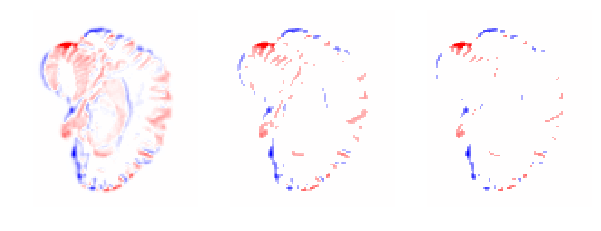

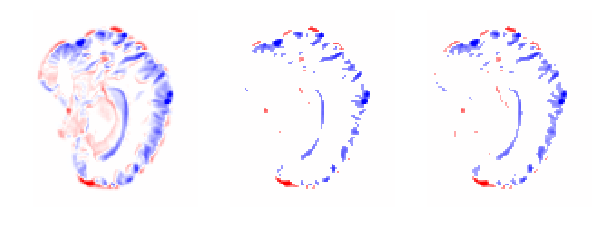

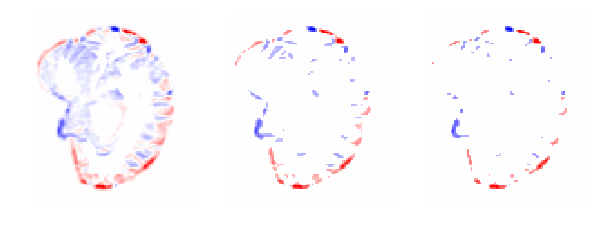

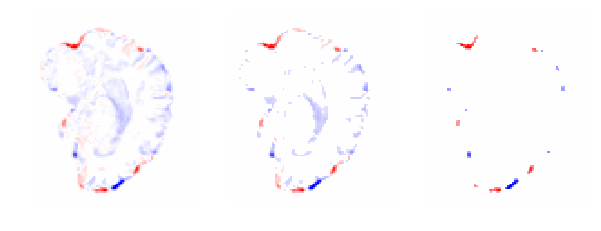

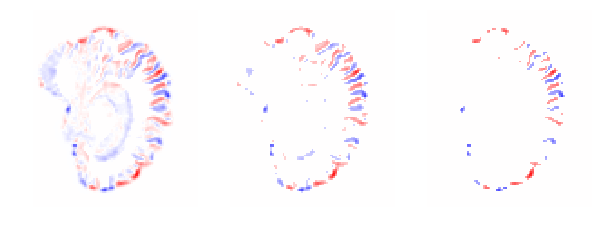

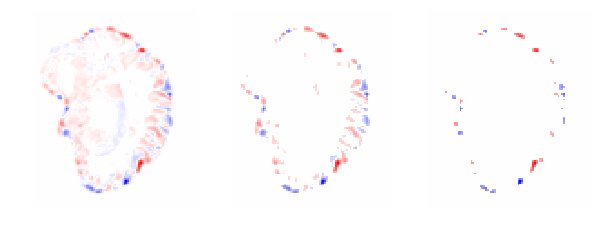

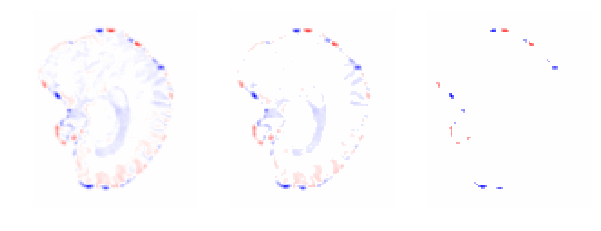

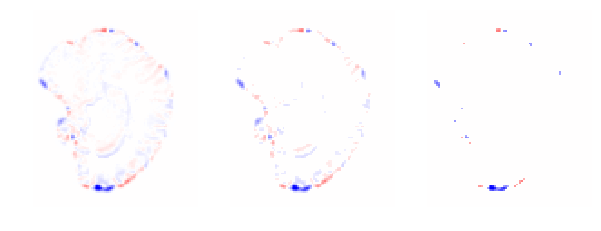

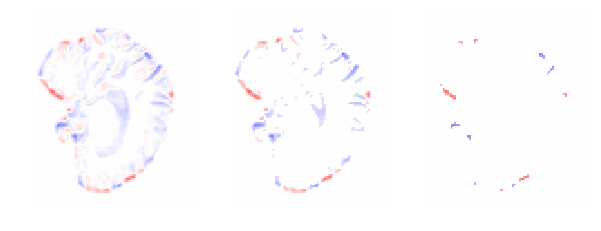

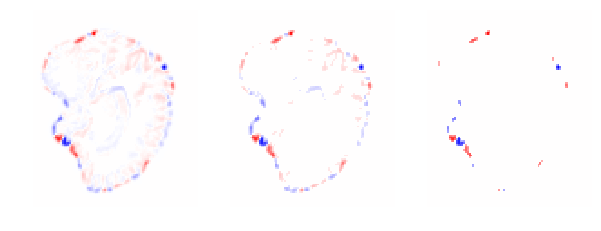

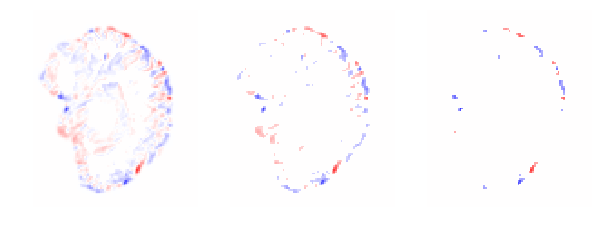

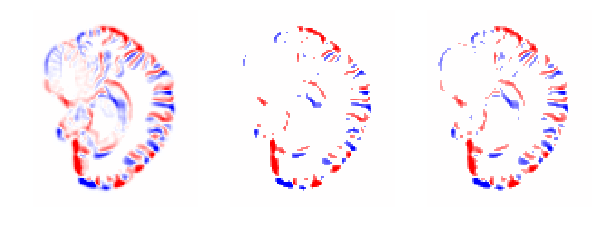

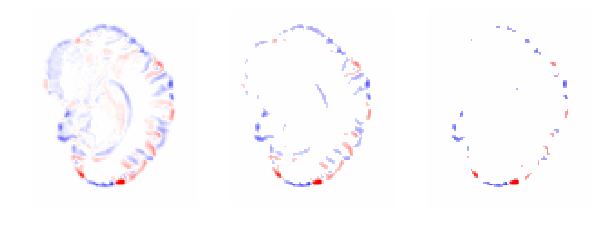

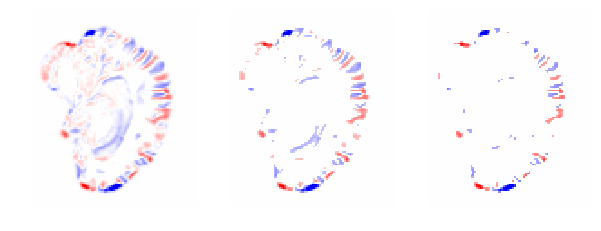

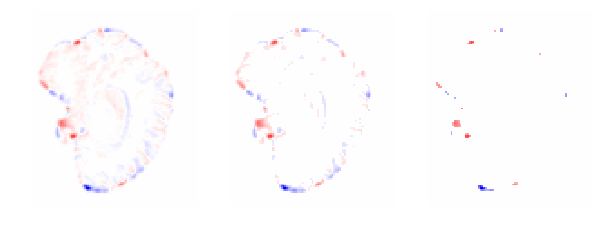

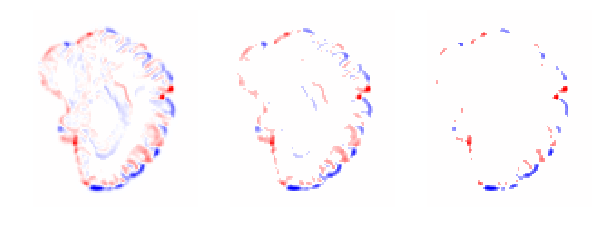

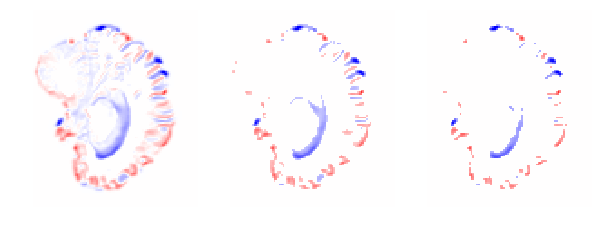

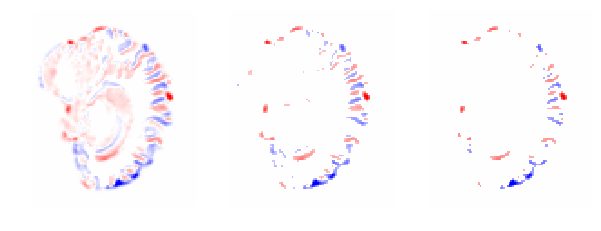

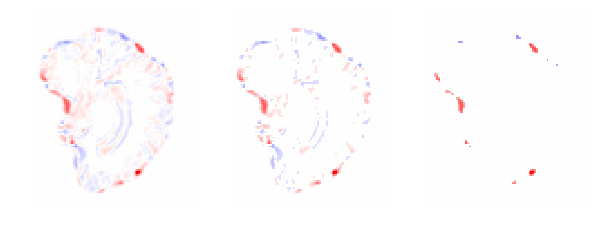

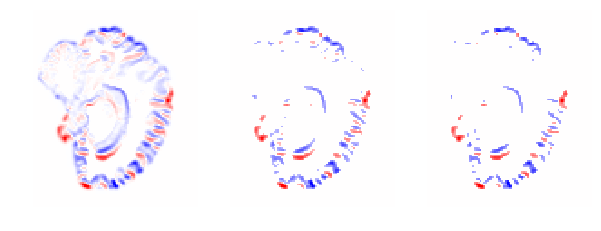

In [33]:
def percentile_smooth(im, percentile=50):
    cp = np.copy(im)
    t = np.percentile(np.abs(cp), percentile)
    mask = np.abs(cp) < t
    cp[mask] = 0
    return cp
    
def hard_threshold(im, thresh=.8):
    cp = np.copy(im)
    mask = np.abs(cp) < thresh
    cp[mask] = 0
    return cp
    
pairs = wrapper.data.test_pairs
np.random.shuffle(pairs)
for im_pair in pairs[:n_samples]:
    im = im_pair.load()
    diff_map = im[:, :, :, 1]
    
    def get_slice(img):
        img = np.squeeze(img)
        return img[35, :, :]
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(get_slice(diff_map), cmap='bwr', vmin=-1, vmax=1)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(get_slice(percentile_smooth(diff_map, 95)), cmap='bwr', vmin=-1, vmax=1)
    plt.axis('off')
               
    plt.subplot(1, 3, 3)
    plt.imshow(get_slice(hard_threshold(diff_map, .3)), cmap='bwr', vmin=-1, vmax=1)
    plt.axis('off')